# Import Libraries and connect database

In [35]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


In [36]:
conn = sqlite3.connect("CID_database_clean.db")


# View table names

In [37]:
pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)


,name
0,dim_environment
1,dim_location
2,dim_demographic
3,fact_school_outcomes
4,sqlite_sequence


# Load datasets into notebook and inspection

In [38]:
fact = pd.read_sql("SELECT * FROM fact_school_outcomes", conn)
demo = pd.read_sql("SELECT * FROM dim_demographic", conn)
env = pd.read_sql("SELECT * FROM dim_environment", conn)
loc = pd.read_sql("SELECT * FROM dim_location", conn)


In [39]:
fact.head()
demo.head()
env.head()
loc.head()


,DBN,school_name,borough,district,school_identifier,latitude,longitude,geometry
0,01M292,Orchard Collegiate Academy,Manhattan,1,292,40.713362,-73.986051,POINT (-8236089.5231 4970154.115800001)
1,01M448,University Neighborhood High School,Manhattan,1,448,40.712269,-73.984128,POINT (-8235875.455700001 4969993.595899999)
2,01M450,East Side Community School,Manhattan,1,450,40.729152,-73.982472,POINT (-8235691.1107 4972473.356399998)
3,01M539,"New Explorations into Science, Technology and ...",Manhattan,1,539,40.719416,-73.979581,POINT (-8235369.286 4971043.264300004)
4,01M696,Bard High School Early College,Manhattan,1,696,40.718276,-73.976093,POINT (-8234981.0035999995 4970875.826800004)


In [40]:
fact.info()
demo.info()
env.info()
loc.info()


<class 'pandas.DataFrame'>
RangeIndex: 2024 entries, 0 to 2023
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   fact_id                      2024 non-null   int64  
 1   DBN                          2024 non-null   str    
 2   Subgroup                     2024 non-null   str    
 3   n_count_ccr                  1525 non-null   float64
 4   ccr_rate                     888 non-null    float64
 5   n_count_graduation_rate      1728 non-null   float64
 6   graduation_rate              1002 non-null   float64
 7   n_count_hs_persistence_rate  1733 non-null   float64
 8   hs_persistence_rate          1004 non-null   float64
 9   n_count_90pct_attendance     1441 non-null   float64
 10  attendance_90pct_rate        1201 non-null   float64
 11  n_count_enrollment           1691 non-null   float64
 12  enrollment_rate              975 non-null    float64
 13  readiness_gap                

In [41]:
fact.describe()
env.describe()
demo.describe()


,nearby_student_percent,pct_students_advanced_courses,student_percent,teacher_percent
count,2016.000000,1804.000000,2024.000000,1426.000000
mean,0.240802,0.240384,0.241182,0.293409
std,0.212393,0.246391,0.252272,0.182275
min,0.004000,0.000000,0.000000,0.000000
25%,0.053000,0.034750,0.027000,0.158000
50%,0.184500,0.154500,0.150000,0.258000
75%,0.368000,0.370500,0.380000,0.417000
max,0.862000,1.000000,1.000000,0.899000


In [42]:
fact.isna().sum()
demo.isna().sum()
env.isna().sum()
loc.isna().sum()


DBN                  0
school_name          0
borough              0
district             0
school_identifier    0
latitude             0
longitude            0
geometry             0
dtype: int64

In [43]:
fact["DBN"].nunique()
env["DBN"].nunique()
loc["DBN"].nunique()
demo["DBN"].nunique()


506

In [44]:
fact["Subgroup"].unique()
demo["Subgroup"].unique()


<StringArray>
['Asian', 'Black', 'Hispanic', 'White']
Length: 4, dtype: str

# Merge tables

In [45]:
df = fact.copy()

# join demographic
df = df.merge(demo, on=["DBN","Subgroup"], how="left")

# join environment
df = df.merge(env, on="DBN", how="left")

# join location
df = df.merge(loc, on="DBN", how="left")

df.head()
df.shape

# drop two schools that were sketchy
df = df[~df["DBN"].isin(["84X648", "84X649"])]

# correct ccr so its in percentage form (.xx)
df["ccr_rate"] = df["ccr_rate"] * 100



# Checking Performance Skew and Gap

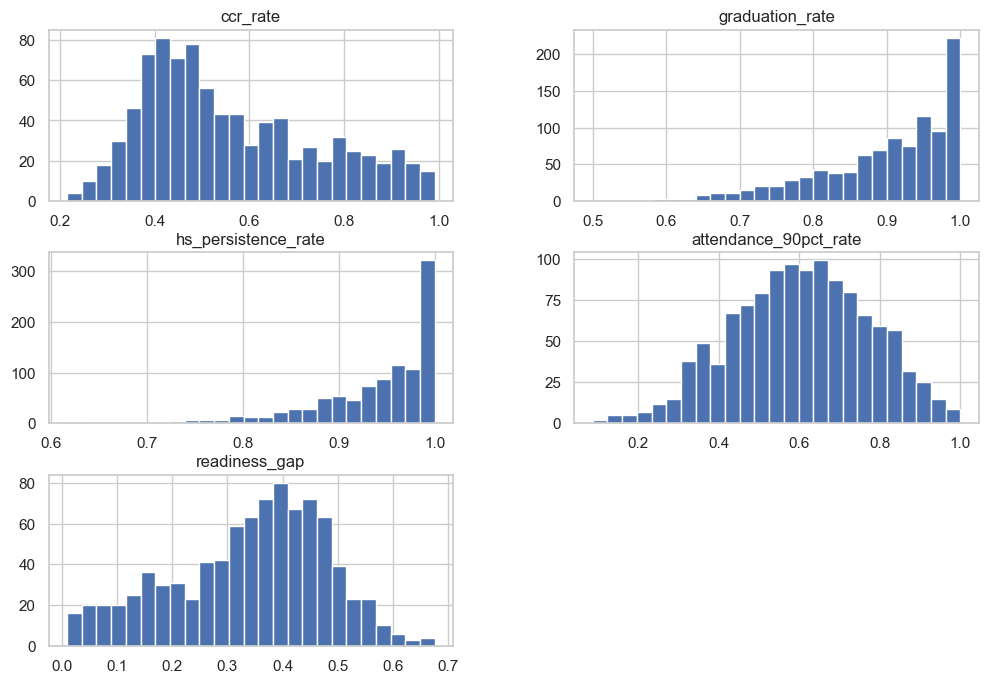

In [46]:
outcomes = [
    "ccr_rate",
    "graduation_rate",
    "hs_persistence_rate",
    "attendance_90pct_rate",
    "readiness_gap"
]

df[outcomes].hist(figsize=(12,8), bins=25)
plt.show()

# X-axis is the rate for each graph.

# CCR Rate - the percentage of students who meet NYC DOE benchmarks for readiness through
# metrics like test scores, course performance, and graduation requirements. 
# (Cohort: 1, 2021-2025)

# Graduation Rate - the percentage of students who graduate high school within four years out of
# the total cohort of students. 
# (Cohort: 1, 2021-2025)

# HS Persistence Rate - the percentage of students who remain enrolled in high school or graduate 
# rather than dropping out. 
# (Cohort: 1, 2021-2025) 

# Pct Attendance >90% - the percentage of students who attend school at least 90% of instructional
# days. 
# (Cohort: Current Enrolled Students at School)


# Readiness Gap - the difference between the graduation rate and college/career readiness rate,
# indicating how many students graduate but are not fully prepared for postsecondary success.
# (Cohort: 1, 2021-2025)


# Y-axis is # of Schools

In [47]:
df[outcomes].describe()


,ccr_rate,graduation_rate,hs_persistence_rate,attendance_90pct_rate,readiness_gap
count,888.000000,1000.000000,1002.000000,1199.000000,888.000000
mean,0.562199,0.899269,0.941223,0.603795,0.339856
std,0.184521,0.093099,0.064327,0.170608,0.140622
min,0.215000,0.500000,0.617000,0.087000,0.009000
25%,0.418000,0.849750,0.907250,0.483000,0.250750
50%,0.513000,0.923000,0.959000,0.608000,0.363000
75%,0.685250,0.971000,1.000000,0.726000,0.442250
max,0.991000,1.000000,1.000000,1.000000,0.676000


In [48]:
df.groupby("Subgroup")[outcomes].mean().sort_values("ccr_rate", ascending=False)


,ccr_rate,graduation_rate,hs_persistence_rate,attendance_90pct_rate,readiness_gap
Subgroup,,,,,
Asian,0.774475,0.956933,0.975658,0.723511,0.182458
White,0.742980,0.940912,0.967265,NaN,0.197310
Hispanic,0.503851,0.881412,0.927844,0.569736,0.378087
Black,0.488552,0.889067,0.938059,0.579100,0.403518


# Graphing (School Level Granularity)

### Box Plot: CCR Rate by Subgroup 

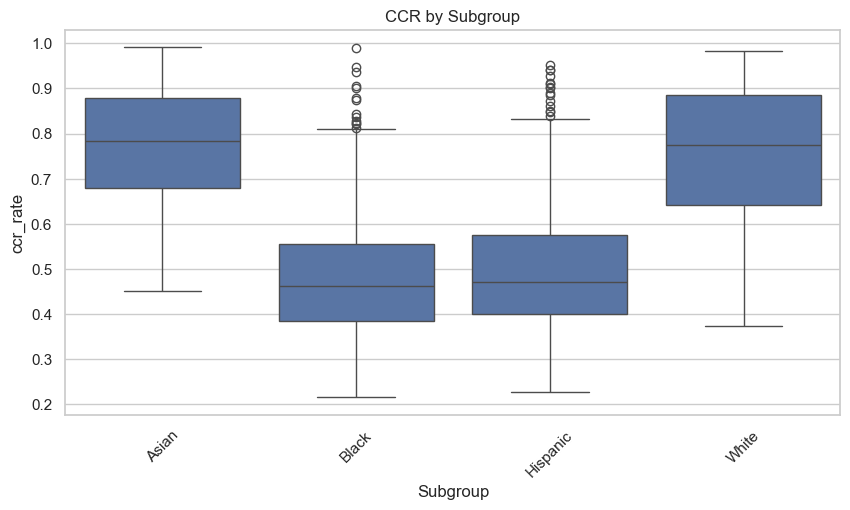

In [49]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df, x="Subgroup", y="ccr_rate")
plt.xticks(rotation=45)
plt.title("CCR by Subgroup")
plt.show()


###### Notes:
###### - Black & Hispanic subgroups show a lower average CCR than Asian & White
###### - Interesting that there are no outliers below Asian & White but there are outliers above Black & Hispanic

### Correlation Matrix : Environmental Factors + School Performance

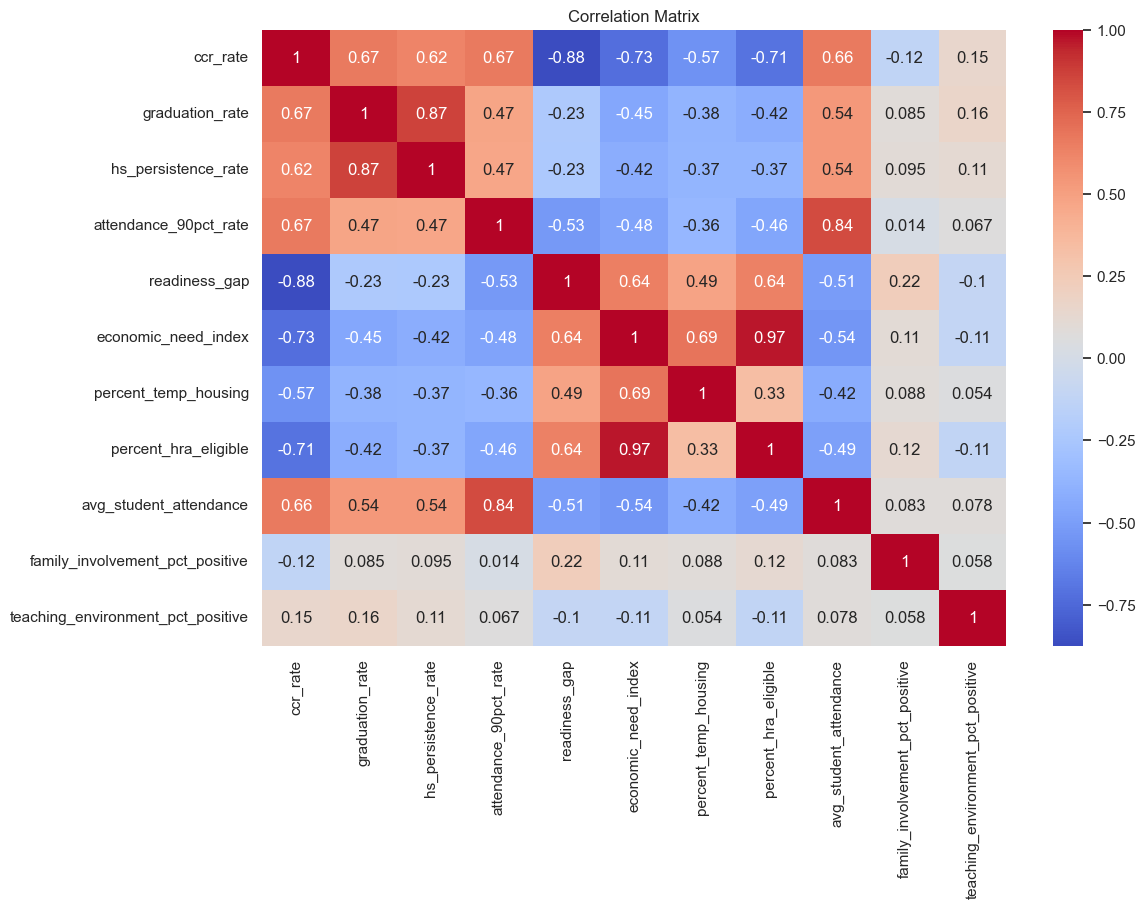

In [50]:
env_cols = [
    "economic_need_index",
    "percent_temp_housing",
    "percent_hra_eligible",
    "avg_student_attendance",
    "family_involvement_pct_positive",
    "teaching_environment_pct_positive"
]

corr_df = df[outcomes + env_cols]

plt.figure(figsize=(12,8))
sns.heatmap(corr_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


###### Notes: 
###### - Above graph has strong negative correlation between CCR and Readiness Gap which is exactly what we expect to see
###### - Has fairly strong negative correlation between ENI and % HRA eligible, indicating that success in school decreases with an increase and poverty

### Scatterplot: ENI vs CCR Rate

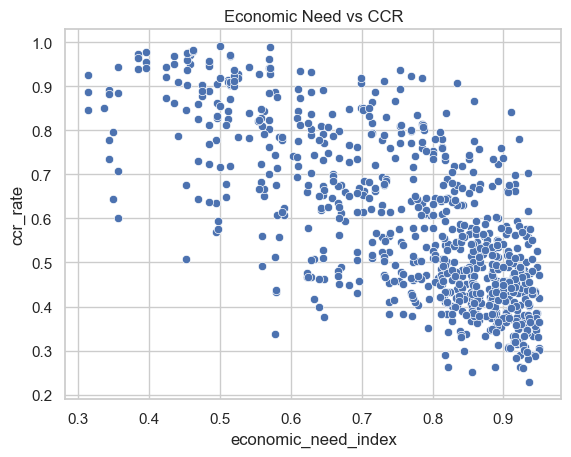

In [51]:
sns.scatterplot(data=df, x="economic_need_index", y="ccr_rate")
plt.title("Economic Need vs CCR")
plt.show()


###### Notes:
###### - Shows the decline in College and Career readiness as Economic Need increases

### Scatterplot: % of Temporary Housing vs Graduation

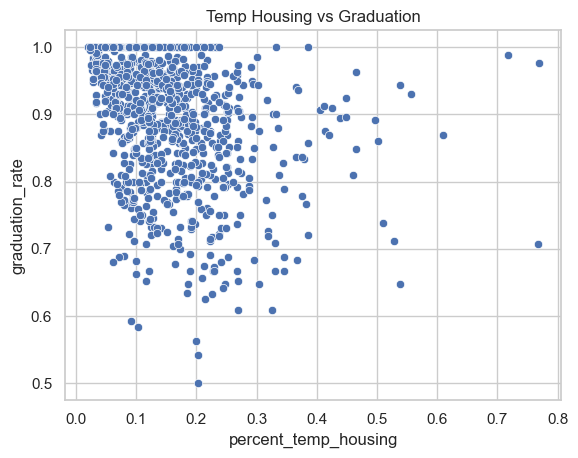

In [52]:
sns.scatterplot(data=df, x="percent_temp_housing", y="graduation_rate")
plt.title("Temp Housing vs Graduation")
plt.show()


###### Notes :
###### - Slight negative correlation # temp housing between gradulation
###### - Meaning higher rates of temporary housing are slighty associated with lower graduation rates


### Bar Chart: CCR Rate by Borough

In [53]:
# Looking at rates by Borough
df.groupby("borough")[outcomes].mean().sort_values("ccr_rate")


,ccr_rate,graduation_rate,hs_persistence_rate,attendance_90pct_rate,readiness_gap
borough,,,,,
Bronx,0.469535,0.884615,0.933607,0.594816,0.409465
Brooklyn,0.516471,0.885381,0.932409,0.581175,0.374613
Queens,0.611660,0.907294,0.944190,0.651119,0.295403
Manhattan,0.634516,0.919401,0.955117,0.592543,0.293641
Staten Island,0.635912,0.913026,0.944000,0.657457,0.272824


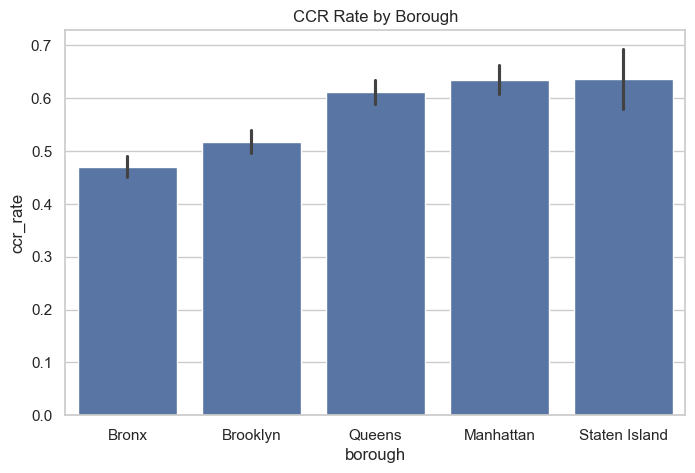

In [54]:
order = df.groupby("borough")["ccr_rate"].mean().sort_values().index

plt.figure(figsize=(8,5))
sns.barplot(data=df, x="borough", y="ccr_rate", order=order)
plt.title("CCR Rate by Borough")
plt.show()


###### Notes:
###### - Shows College and Career Readiness Rate by Borough
###### - Could be important with findings from later graphs

### Scatterplot: % Students in Advanced Courses vs College and Career Readiness Rate

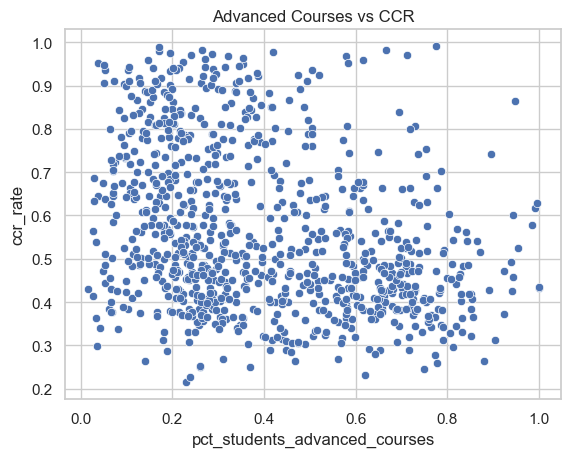

In [55]:
sns.scatterplot(data=df, 
                x="pct_students_advanced_courses", 
                y="ccr_rate")
plt.title("Advanced Courses vs CCR")
plt.show()


###### Notes:
###### - No strong linear relationship,  Advanced Courses don't have much of an impact on a student's readiness


### Scatterplot: Avg Student Attendance vs Graduation Rate

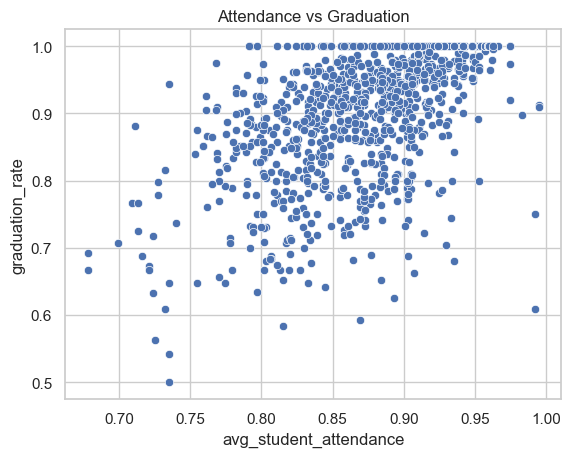

In [56]:
sns.scatterplot(data=df, x="avg_student_attendance", y="graduation_rate")
plt.title("Attendance vs Graduation")
plt.show()


###### Notes:
###### - Shows strong positive correlation 
###### - Students with high attendance tend to graduate
###### - Does not speak directly to our point of factors affecting future readiness, but still important I think

### Histogram: Readiness Gap

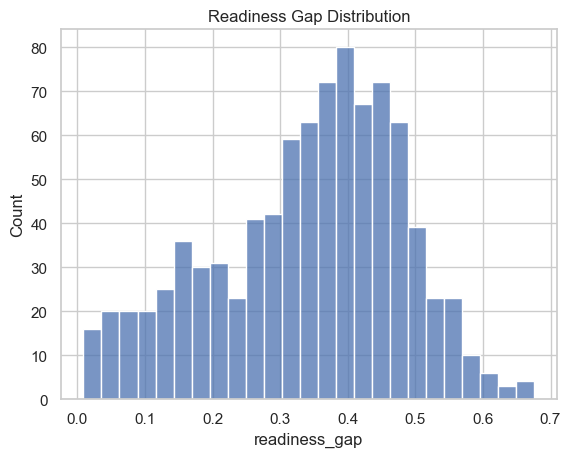

In [57]:
sns.histplot(df["readiness_gap"], bins=25)
plt.title("Readiness Gap Distribution")
plt.show()


###### Notes: 
###### - Readiness Gap is Graduation Rate - CCR Rate
###### - Shows that there is a spike in schools that have a readiness gap of around .4, or 40%
###### - Shocking because shows that there is a 40% difference in students that graduate, and students that are ready for what comes after they graduate

# Outlier check

In [58]:
df = df.rename(columns={
    "school_name_x": "school_name"
})


In [59]:
df.sort_values("readiness_gap", ascending=False)[
    ["school_name","borough","readiness_gap"]
].head(10)


,school_name,borough,readiness_gap
593,Bronx High School of Business,Bronx,0.676
793,High School for Contemporary Arts,Bronx,0.661
805,"Metropolitan High School, The",Bronx,0.655
1021,Nelson Mandela High School,Brooklyn,0.650
798,Bronx Aerospace High School,Bronx,0.634
1270,Origins High School,Brooklyn,0.626
273,"Urban Assembly School for Media Studies, The",Manhattan,0.625
1174,School for Classics High School,Brooklyn,0.620
1093,Brooklyn Theatre Arts High School,Brooklyn,0.612
1521,High School for Law Enforcement and Public Safety,Queens,0.609


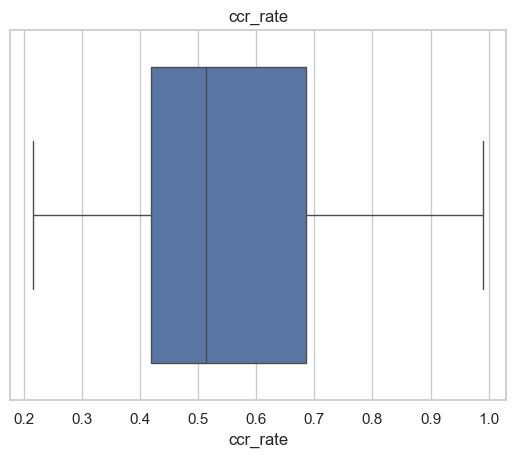

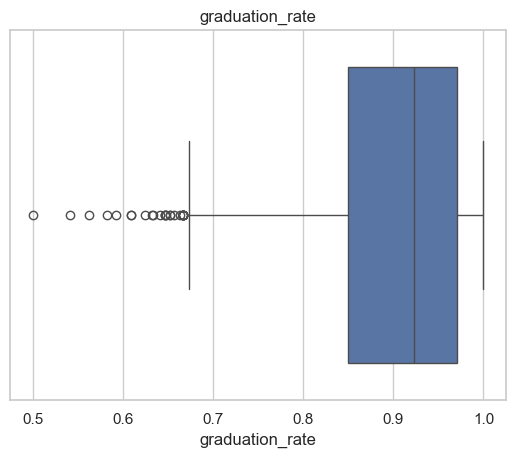

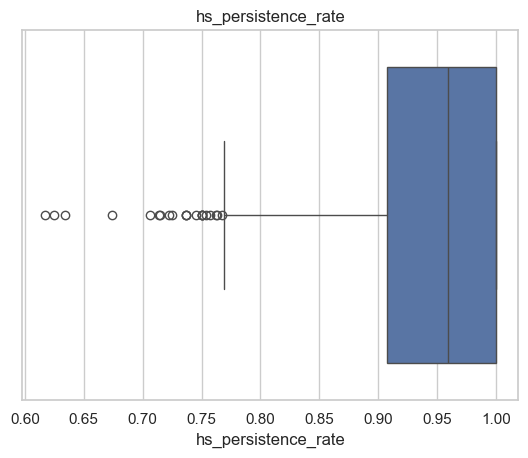

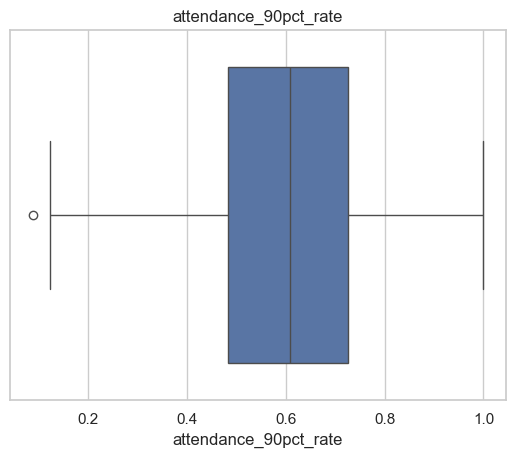

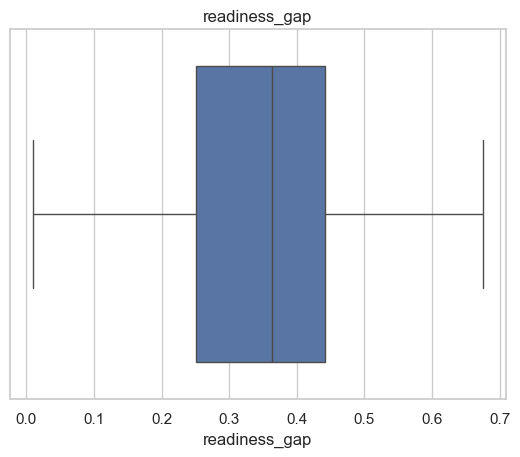

In [60]:
for col in outcomes:
    sns.boxplot(x=df[col])
    plt.title(col)
    plt.show()


# Geopandas, Mapping

In [61]:
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx

In [62]:
# selects the preferred school_name column after merges created suffixes
name_col = "school_name_y" if "school_name_y" in df.columns else "school_name"

# create a temporray df with the columns needed for mapping and weighted CCR
tempdf = df.dropna(subset=["DBN", "latitude", "longitude", "n_count_ccr", "ccr_rate"]).copy()

# weighted school-level dataset, puts back on School-Level granularity instead School>Subgroup-Level.
# Makes sure there's only one point per DBN instead of 4, 1 for each subgroup

school_df = (
    tempdf.groupby("DBN")
        # makes group for each school
       .apply(lambda g: pd.Series({
           "school_name": g[name_col].iloc[0],
           "borough": g["borough"].iloc[0],
           "district": g["district"].iloc[0] if "district" in g.columns else None,
           "latitude": g["latitude"].iloc[0],
           "longitude": g["longitude"].iloc[0],

           # adds context for each school
           "economic_need_index": g["economic_need_index"].iloc[0],
           "percent_hra_eligible": g["percent_hra_eligible"].iloc[0],
           "percent_temp_housing": g["percent_temp_housing"].iloc[0],
           "avg_student_attendance": g["avg_student_attendance"].iloc[0],

           # weights CCR and graduation by cohort (4-year, cohort: 1, 2021-2024)
           "ccr_rate": (g["ccr_rate"] * g["n_count_ccr"]).sum() / g["n_count_ccr"].sum(),

           "graduation_rate": (
               (g["graduation_rate"] * g["n_count_graduation_rate"]).sum()
               / g["n_count_graduation_rate"].sum()
               if "n_count_graduation_rate" in g.columns and g["n_count_graduation_rate"].notna().any()
               else np.nan
           )
       }))
       .reset_index()
)

# readiness gap 
school_df["readiness_gap"] = school_df["graduation_rate"] - school_df["ccr_rate"]

school_df.head()


,DBN,school_name,borough,district,latitude,longitude,economic_need_index,percent_hra_eligible,percent_temp_housing,avg_student_attendance,ccr_rate,graduation_rate,readiness_gap
0,01M292,Orchard Collegiate Academy,Manhattan,1,40.713362,-73.986051,0.911,0.837,0.190,0.818,0.582565,0.934848,0.352283
1,01M448,University Neighborhood High School,Manhattan,1,40.712269,-73.984128,0.719,0.639,0.097,0.915,0.768495,1.000000,0.231505
2,01M450,East Side Community School,Manhattan,1,40.729152,-73.982472,0.658,0.520,0.101,0.935,0.692967,0.983410,0.290443
3,01M539,"New Explorations into Science, Technology and ...",Manhattan,1,40.719416,-73.979581,0.436,0.366,0.029,0.941,0.940800,0.989800,0.049000
4,01M696,Bard High School Early College,Manhattan,1,40.718276,-73.976093,0.496,0.404,0.053,0.919,0.858363,0.967871,0.109508


In [63]:
school_gdf = gpd.GeoDataFrame(
    school_df.dropna(subset=["latitude", "longitude"]).copy(),
    geometry=gpd.points_from_xy(school_df["longitude"], school_df["latitude"]),
    crs="EPSG:4326"
)

# sanity check: should be 1 row per DBN
print("Rows:", len(school_gdf), "| Unique DBNs:", school_gdf["DBN"].nunique())
school_gdf.head()


Rows: 411 | Unique DBNs: 411


,DBN,school_name,borough,district,latitude,longitude,economic_need_index,percent_hra_eligible,percent_temp_housing,avg_student_attendance,ccr_rate,graduation_rate,readiness_gap,geometry
0,01M292,Orchard Collegiate Academy,Manhattan,1,40.713362,-73.986051,0.911,0.837,0.190,0.818,0.582565,0.934848,0.352283,POINT (-73.98605 40.71336)
1,01M448,University Neighborhood High School,Manhattan,1,40.712269,-73.984128,0.719,0.639,0.097,0.915,0.768495,1.000000,0.231505,POINT (-73.98413 40.71227)
2,01M450,East Side Community School,Manhattan,1,40.729152,-73.982472,0.658,0.520,0.101,0.935,0.692967,0.983410,0.290443,POINT (-73.98247 40.72915)
3,01M539,"New Explorations into Science, Technology and ...",Manhattan,1,40.719416,-73.979581,0.436,0.366,0.029,0.941,0.940800,0.989800,0.049000,POINT (-73.97958 40.71942)
4,01M696,Bard High School Early College,Manhattan,1,40.718276,-73.976093,0.496,0.404,0.053,0.919,0.858363,0.967871,0.109508,POINT (-73.97609 40.71828)


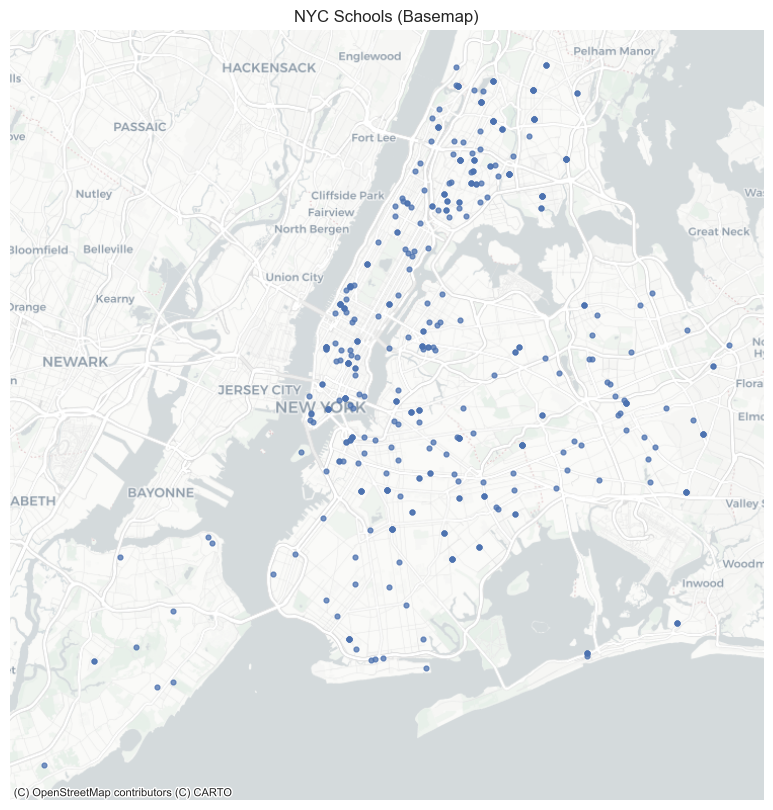

In [64]:
school_gdf_3857 = school_gdf.to_crs(epsg=3857)

ax = school_gdf_3857.plot(figsize=(10,10), markersize=12, alpha=0.75)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_axis_off()
plt.title("NYC Schools (Basemap)")
plt.show()


### College and Career Readiness Across Boroughs with Color Mapping

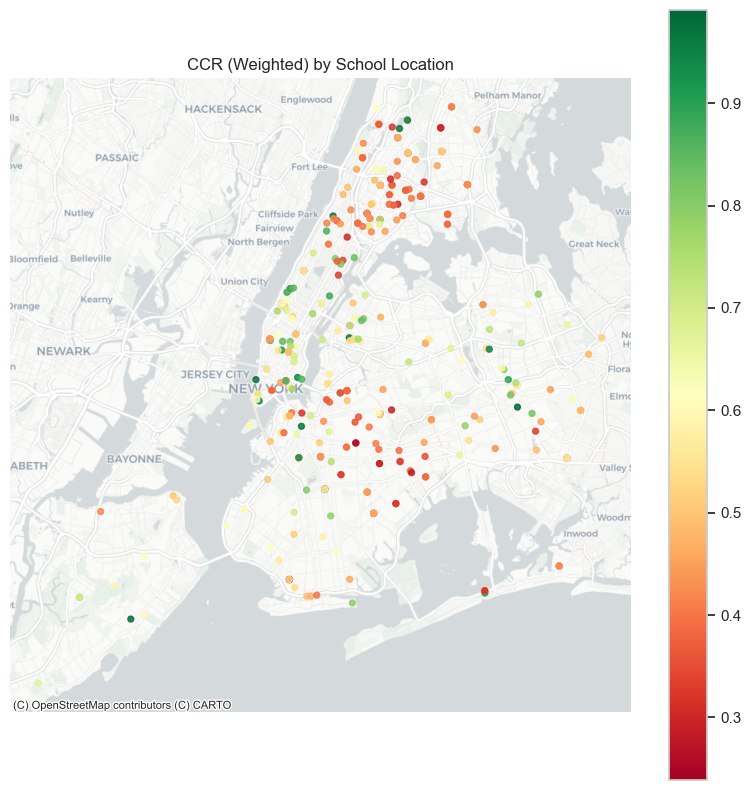

In [65]:
ax = school_gdf_3857.plot(
    cmap='RdYlGn',
    column="ccr_rate",
    legend=True,
    figsize=(10,10),
    markersize=18,
    alpha=0.85
)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_axis_off()
plt.title("CCR (Weighted) by School Location")
plt.show()


###### Notes:
###### - Brooklyn, Bronx, Partially Queens, need most help improving CCR.
###### - Consistent with the box plot from earlier

### ENI Across Boroughs with Color Mapping

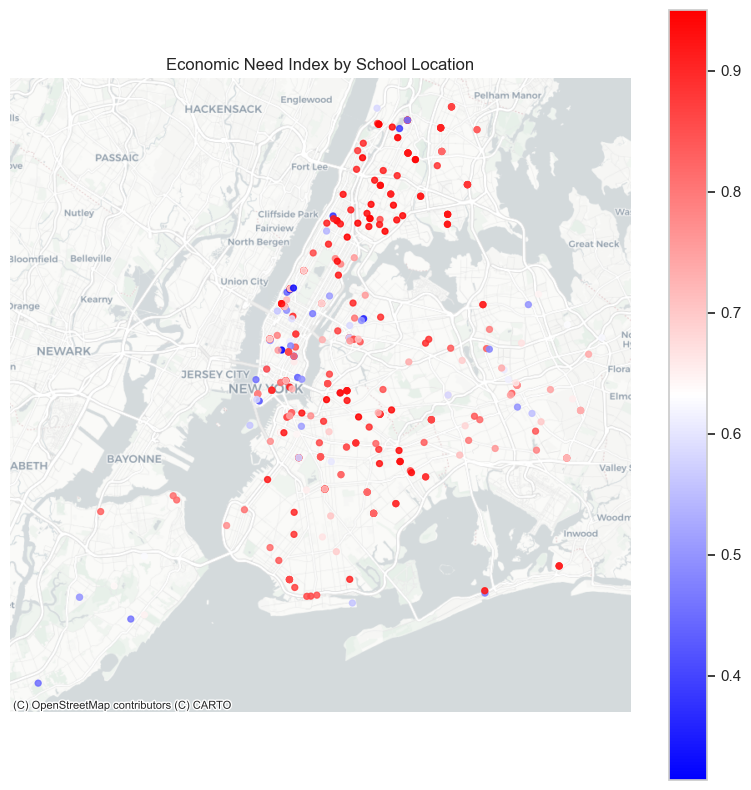

In [66]:
ax = school_gdf_3857.plot(
    cmap='bwr',
    column="economic_need_index",
    legend=True,
    figsize=(10,10),
    markersize=18,
    alpha=0.85
)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_axis_off()
plt.title("Economic Need Index by School Location")
plt.show()


###### Notes:
###### - Heavy Economic Need in the Bronx, Brooklyn, and slightly lighter in Queens, consistent with CCR 
###### - Indicative of this being a factor, basically mapping the correlation matrix

### Reading Gap Across Borough with Color Mapping

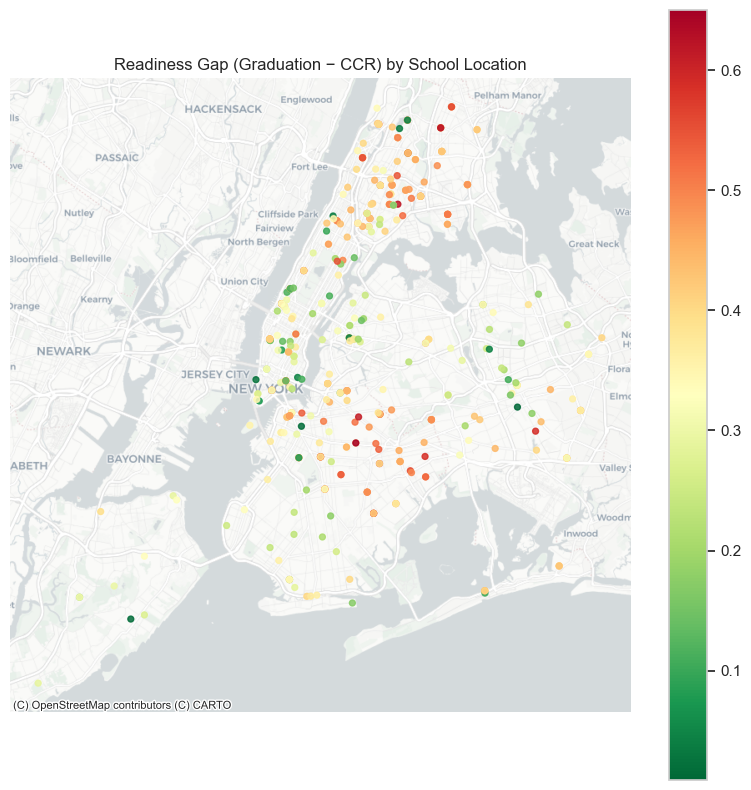

In [67]:
gap_gdf = school_gdf_3857.dropna(subset=["readiness_gap"])

ax = gap_gdf.plot(
    cmap='RdYlGn_r',
    column="readiness_gap",
    legend=True,
    figsize=(10,10),
    markersize=18,
    alpha=0.85
)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_axis_off()
plt.title("Readiness Gap (Graduation − CCR) by School Location")
plt.show()


###### Notes: 
###### - Again, similar trends. Bronx and Brooklyn are stuggling, Queens isn't too far behind

### Interactive Map of Schools Across Boroughs
##### Includes DBN, Borough, CCR(Weighted by Cohort), Graduation(Weighted by Cohort), Readiness Gap, ENI, Attendance

In [68]:
import folium
from folium.plugins import MarkerCluster

# color codes dots based of CCR
def color_scale(ccr):
    if pd.isna(ccr):
        return "gray"
    if ccr >= 0.8: return "green"
    if ccr >= 0.6: return "orange"
    return "red"

# filters only schools with valid longitude and latitude, meaning no NA
map_df = school_df.dropna(subset=["latitude","longitude"]).copy()

# focuses on NYC and makes dots cluster together when zoomed out
doemap = folium.Map(location=[40.7, -73.95], zoom_start=10)
cluster = MarkerCluster().add_to(doemap) 

# adds pop ups to dots
for _, row in map_df.iterrows():
    popup_text = f"""
    <b>{row['school_name']}</b><br>
    DBN: {row['DBN']}<br>
    Borough: {row.get('borough','')}<br>
    CCR (weighted): {row['ccr_rate']:.2f}<br>
    Graduation (weighted): {row['graduation_rate']:.2f}<br>
    Readiness Gap: {row['readiness_gap']:.2f}<br>
    ENI: {row['economic_need_index']:.2f}<br>
    Attendance: {row['avg_student_attendance']:.2f}
    """

# adds everything to the map
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=6,
        popup=folium.Popup(popup_text, max_width=350),
        tooltip=row["school_name"],
        color=color_scale(row["ccr_rate"]),
        fill=True,
        fill_color=color_scale(row["ccr_rate"]),
        fill_opacity=0.85
    ).add_to(cluster)

doemap


###### Notes:
###### - * When combining subgroup performance into a single school-level value, rates were weighted by subgroup student counts so that larger student populations have greater influence on the overall metric, producing a more accurate representation of school-wide outcomes.
###### - Some dots overlap because there are multiple schools at the same address.
###### - Dots are color coded by CCR:
###### Green: >= 0.80
###### Yellow: < 0.80 & 0.60 =>
###### Red: > .60 